# Teletransportación con diferentes estados de Bell Entrelazados

In [1]:
# Importamos algunas cosas necesarias
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.result import marginal_counts
from qiskit import quantum_info

In [2]:
# Preparación de estado inicial
psi = Statevector(random_statevector(2))
psi.draw('latex')

<IPython.core.display.Latex object>

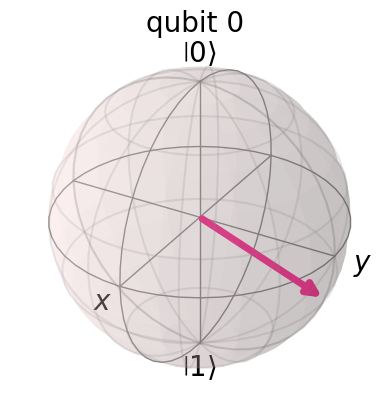

In [3]:
plot_bloch_multivector(psi)

In [4]:
# Función que genera los 4 estados de Bell
def crear_estado_de_bell(circuito, qubits, bell):
    circuito.h(qubits[0])
    circuito.cx(qubits[0], qubits[1])
    match bell:
        case "01":
            circuito.x(qubits[1])
        case "10":
            circuito.z(qubits[1])
        case "11":
            circuito.x(qubits[1])
            circuito.z(qubits[0])
        case "00":
            print("nada")
            
def alice_operaciones(circuito, qubit0, qubit1):
    circuito.cx(qubit0, qubit1)
    circuito.h(qubit0)

def medir_luego_enviar(circuito, qubit0, qubit1, bit1, bit2):
    circuito.measure(qubit0, bit1)
    circuito.measure(qubit1, bit2)
    
def bob_operaciones(circuito, qubits, bit1, bit2, bell):
    circuito.x(qubits[2]).c_if(bit2, not int(bell[1])) #El bit2 es resultado de medir q1
    circuito.z(qubits[2]).c_if(bit1, not int(bell[0])) #El bit1 es resultado de medir q0
    #Se aplicarán las puertas X ó Z en función del estado de Bell utilizado
    
def teleportation(psi, bell_state="00"):
    q0_init_transform = Initialize(psi)
    q2_reverse_transform = q0_init_transform.gates_to_uncompute()
    
    qubits = QuantumRegister(3, name="q")    # Registramos 3 qúbits de nombre "q"
    cbit1 = ClassicalRegister(1, name="cbit1") # Primer bit clásico 
    cbit2 = ClassicalRegister(1, name="cbit2") # Segundo bit clásico
    circuito = QuantumCircuit(qubits, cbit1, cbit2)

    #Inicializamos el qúbit de Alice:
    circuito.append(q0_init_transform, [0]) #agrega la instrucción "q0_init_transform" al final del circuito 
    circuito.barrier()
    
    #El Telamon crea un par de Bell
    crear_estado_de_bell(circuito, [qubits[1], qubits[2]], bell_state)
    circuito.barrier()
    
    #Alice realiza operaciones con sus qubits
    alice_operaciones(circuito, qubits[0], qubits[1])
    #circuito.save_statevector()
    
    #Alice mide sus qúbits y envía por whatsapp a Bob
    medir_luego_enviar(circuito, qubits[0], qubits[1], cbit1, cbit2)
    circuito.barrier()
    
    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, qubits, cbit1, cbit2, bell_state)
    
    return [circuito, qubits]

## Función de Teletransportación

El parámetro **bell_state** recibe como argumento el estado de Bell deseado ("00", "01", "10", "11") de acuerdo a lo siguiente:

<img src="img/estados_bell.png" width="500">

Tomemos como ejemplo **bell_state="01"**:

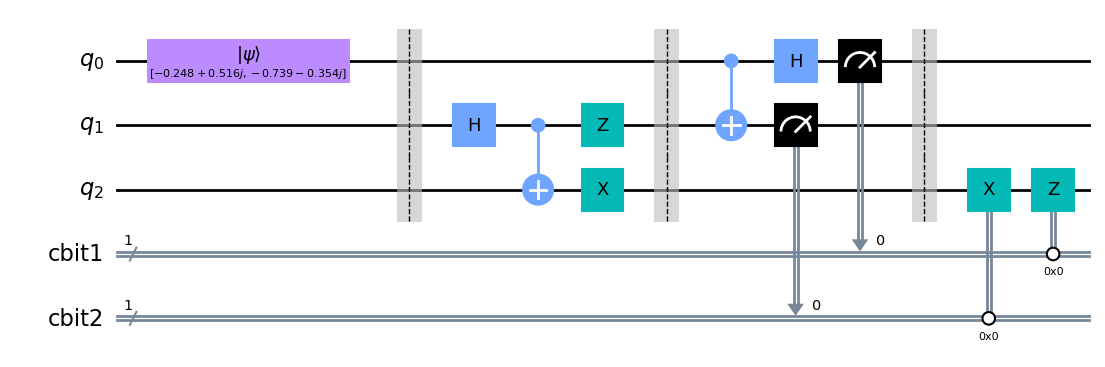

In [5]:
qc, qubits = teleportation(psi, bell_state="11")
qc.draw(output="mpl")

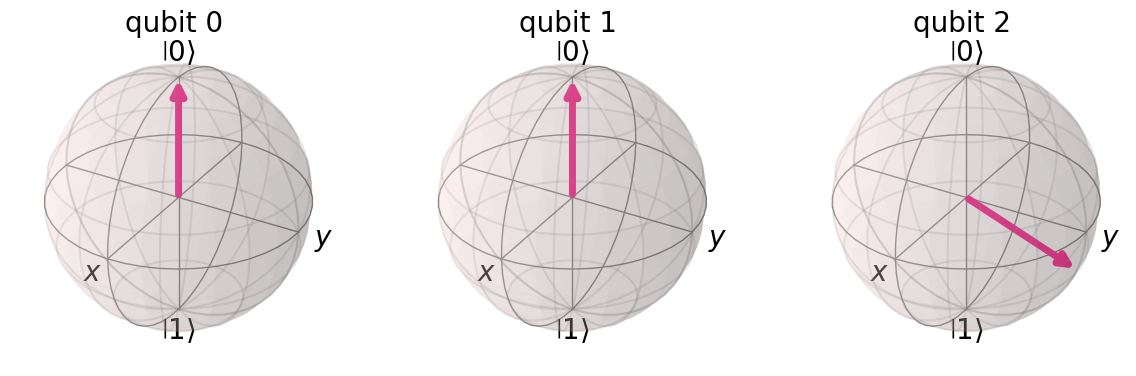

In [6]:
sim = Aer.get_backend("aer_simulator") 
qc.save_statevector() 

#Ejecutamos el circuito en el simulador y accedemos a los resultados, específicamente
#accedemos a los vectores de estado
out = execute(qc, sim).result().get_statevector()
plot_bloch_multivector(out)

In [7]:
out.draw('latex')

<IPython.core.display.Latex object>